In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [5]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.5)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(17.62165241, dtype=float64), c_1=Array(0.00013356, dtype=float64), c_mu=Array(0.00207022, dtype=float64), c_sigma=Array(0.13662043, dtype=float64), d_sigma=Array(1.13662043, dtype=float64), c_c=Array(0.03308797, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [6]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

In [7]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [12]:
import time

state = strategy.initialize(rng, es_params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = strategy.ask(rng_gen, state, es_params)
    fitness = custom_rollout(x)
    state = strategy.tell(x, fitness, state, es_params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: -22.98167
Time: 5.527367830276489
CMA-ES - # Gen: 200|Fitness: -23.11648
Time: 7.633880138397217
CMA-ES - # Gen: 300|Fitness: -23.20703
Time: 9.700785875320435
CMA-ES - # Gen: 400|Fitness: -23.22939
Time: 12.22690725326538
CMA-ES - # Gen: 500|Fitness: -23.23847
Time: 14.204642057418823
CMA-ES - # Gen: 600|Fitness: -23.24628
Time: 16.299262046813965
CMA-ES - # Gen: 700|Fitness: -23.25049
Time: 18.30159902572632
CMA-ES - # Gen: 800|Fitness: -23.25381
Time: 20.5983669757843
CMA-ES - # Gen: 900|Fitness: -23.25593
Time: 22.625993967056274
CMA-ES - # Gen: 1000|Fitness: -23.25911
Time: 24.677792072296143
CMA-ES - # Gen: 1100|Fitness: -23.26147
Time: 26.659456968307495
CMA-ES - # Gen: 1200|Fitness: -23.26346
Time: 28.904031991958618
CMA-ES - # Gen: 1300|Fitness: -23.26686
Time: 30.971323251724243
CMA-ES - # Gen: 1400|Fitness: -23.26721
Time: 32.99925494194031
CMA-ES - # Gen: 1500|Fitness: -23.26753
Time: 34.94928312301636
CMA-ES - # Gen: 1600|Fitness: -23.26764
Tim

KeyboardInterrupt: 

[ 2.32380121  2.32384242  2.3255814   2.32433416  2.32117539  2.32557653
  2.32471425  2.31934618  2.32209129  1.97393838  2.29124291  1.37120012
  1.85960345  1.27934731  1.19058551  1.00899552  1.9610283   1.49053717
  0.39516561  1.71166234  0.44065609  1.56888644  1.43561758  1.64951452
  1.87125779  2.30751341  1.54340107  1.91529059  1.15915895  2.05376886
  1.94951505  1.2203186   2.32106192  0.22778783  2.32498451  0.5193919
  1.23717511  0.69670318  1.40565259  0.32902211  1.42187813 -0.01047248
  0.87322755  0.13856526  0.38372531  0.00339123 -0.09083647  0.51666424
 -0.24090134  1.84800368 -0.54300997  0.91275766 -1.7949248   0.27359369
 -1.81189445 -1.42315315 -0.32957757 -1.88401268  0.08859866 -1.58491391
 -0.47741833 -0.82300221 -2.08550421  0.23518149 -2.27673117 -0.31648008
 -2.31482423 -0.85591184 -2.30606035 -1.43418135 -1.60772466 -1.65424572
 -1.73160381 -1.05763614 -1.50179894  0.3674733  -2.13876106  0.69468057
 -2.1012026  -0.67100614 -0.52702177 -1.04507562 -1.

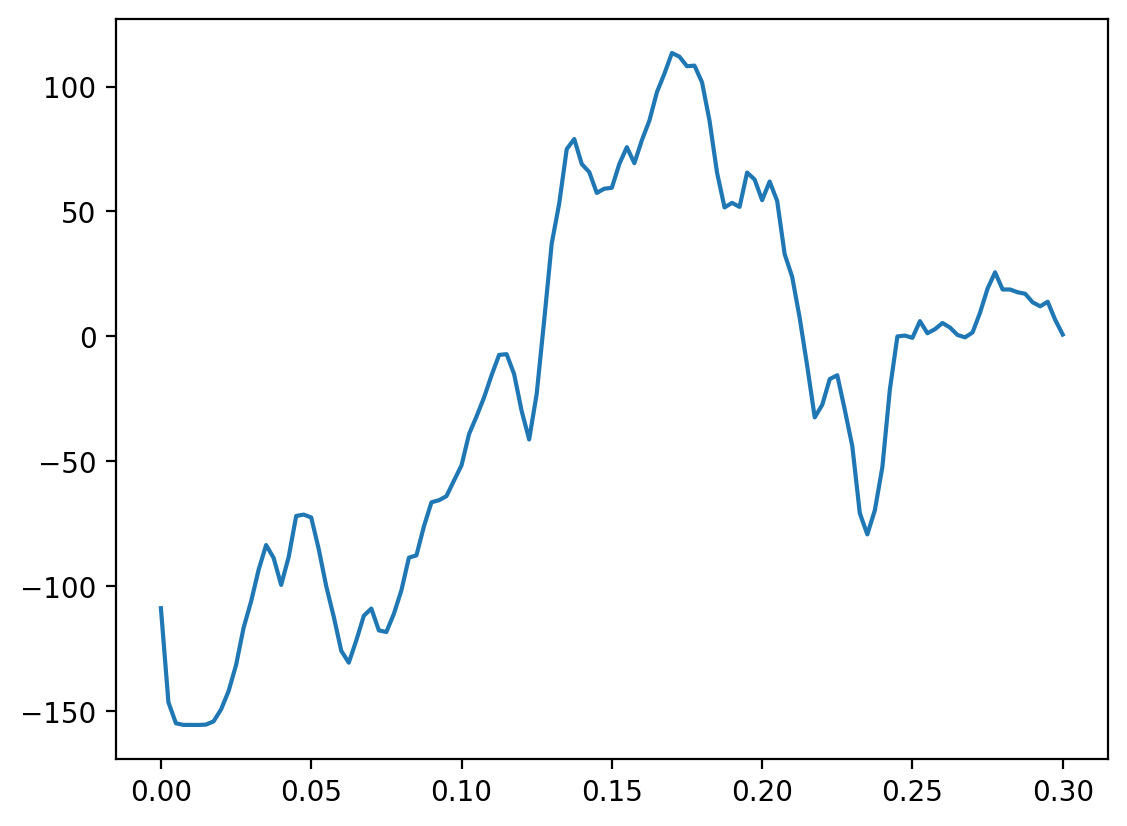

In [13]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [14]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(reward[0])

0.10333333333333336
0.24500000000000005
23.268653435968968


0.06861122552374697
325
0.08162751782031984
299


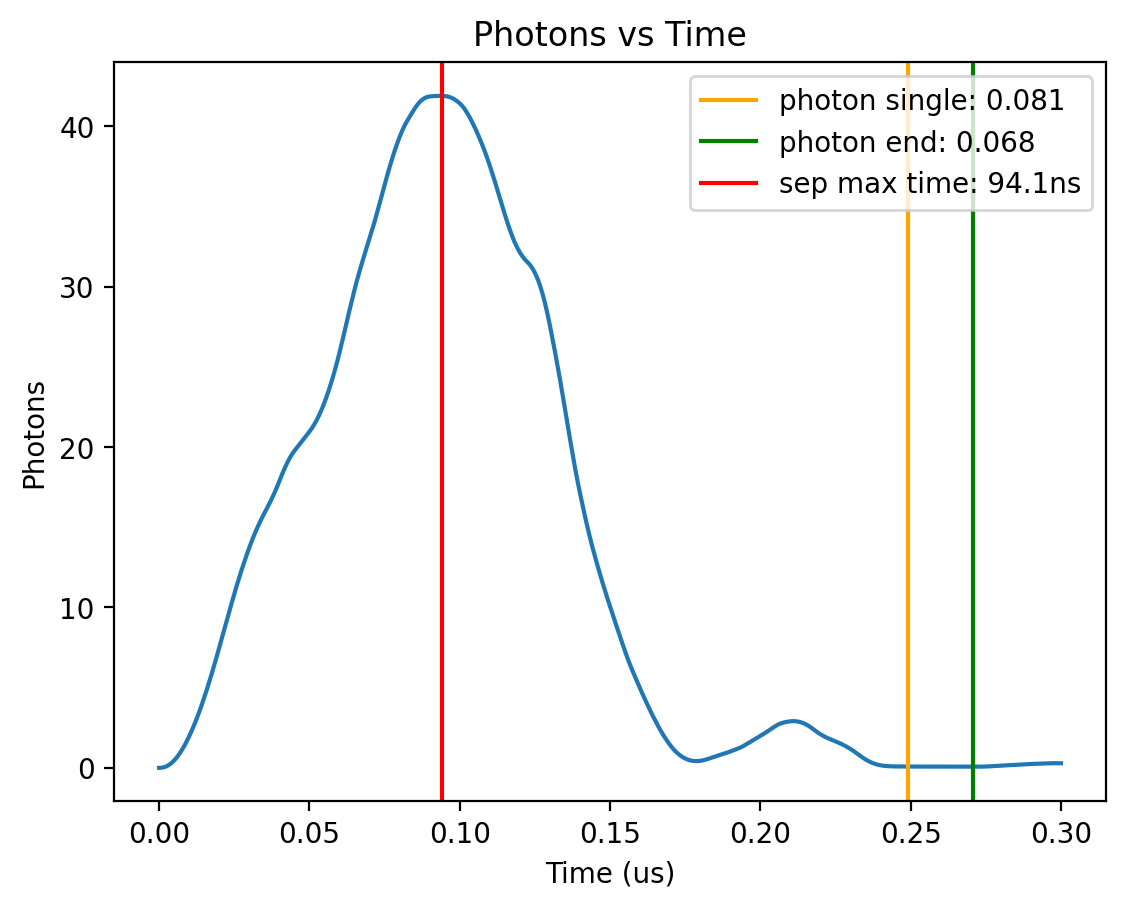

In [15]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = 300
ext_2 = -1

min_photon = jnp.min(single_photon[ext:ext_2])
argmin = jnp.argmin(single_photon[ext:ext_2]) + ext

min_photon_2 = jnp.min(single_photon[ext:ext_15])
argmin_2 = jnp.argmin(single_photon[ext:ext_15]) + ext

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

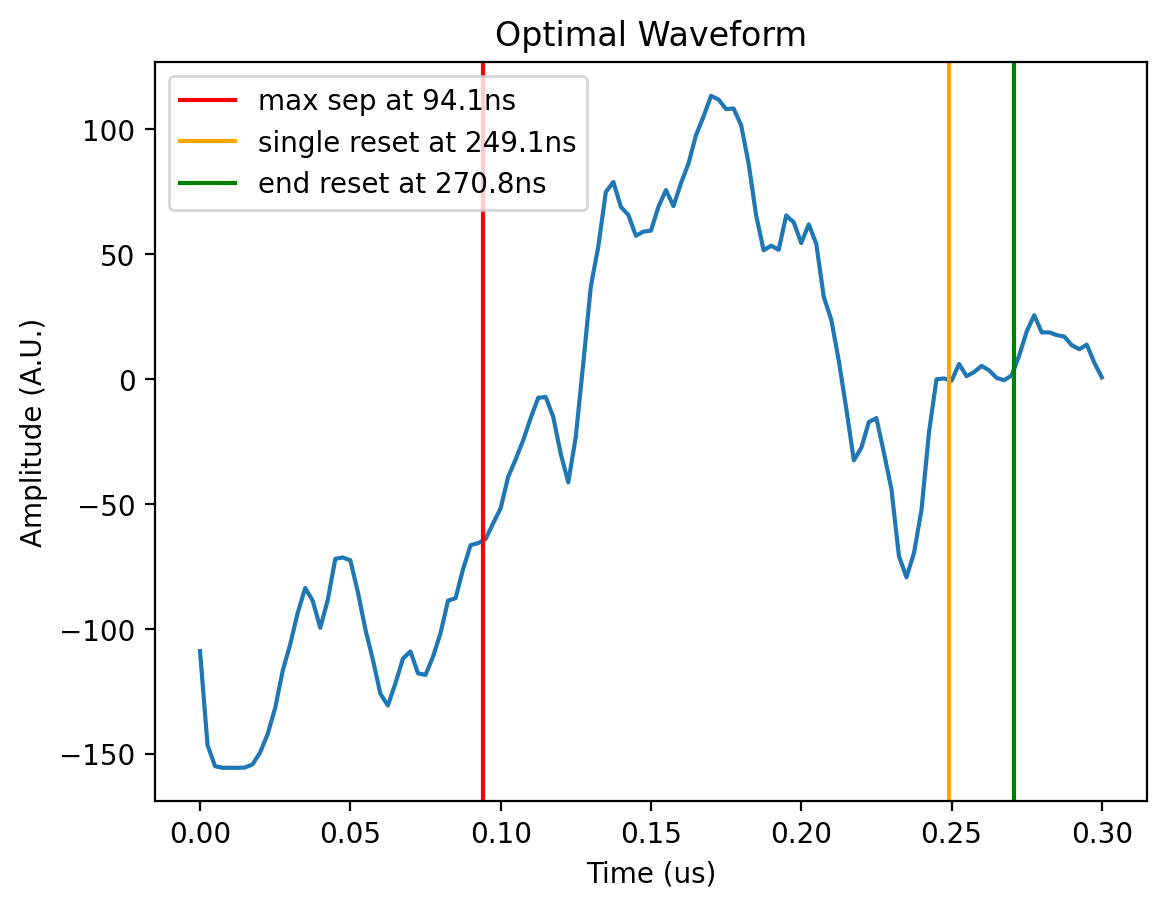

In [16]:
plt.plot(env.ts_action, action)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

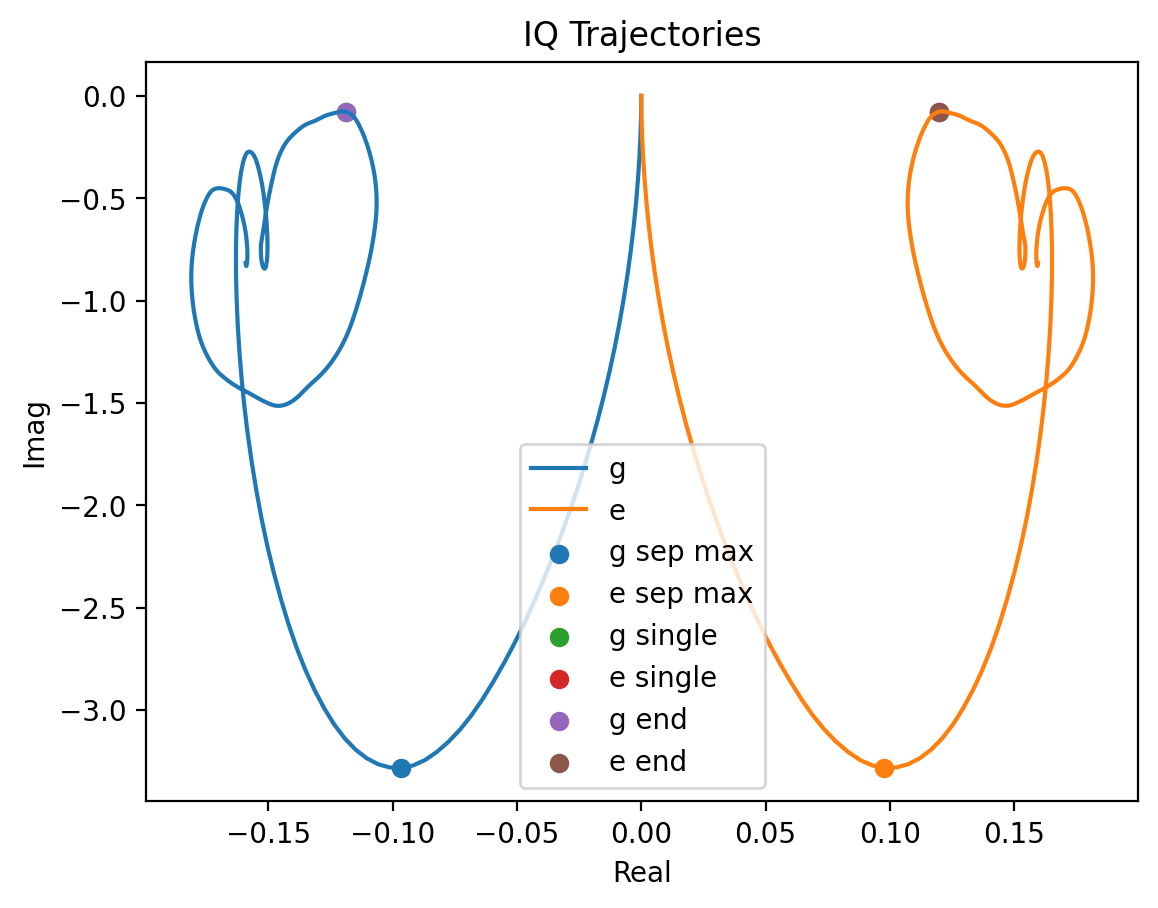

In [13]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

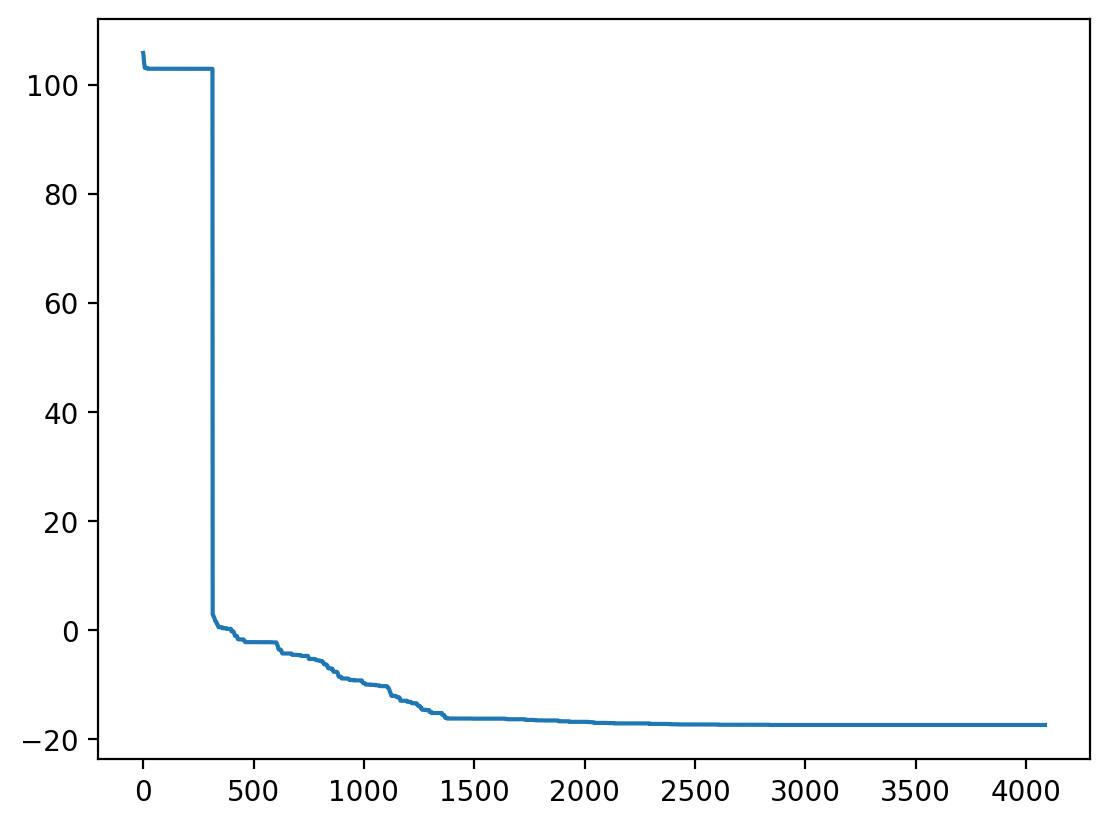

In [ ]:
plt.plot(fitness_list)